In [1]:
import json
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import random
from collections import deque
from gym import spaces

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import csv
import os
import re
import numpy as np
import copy
import warnings
# import seaborn as sns

# 環境參數

In [2]:
# 環境參數
running_time = 282
# 超參數
EPISODES = 500
EPS_START = 0.9  # 隨機選擇行動的概率
EPS_END = 0.05
EPS_DECAY = 200  # epsilon 衰減的速度
GAMMA = 0.8  # 折扣因子
LR = 0.001  # 學習率
MEMORY_SIZE = 10000  # 經驗回放的記憶體大小
BATCH_SIZE = 128  # 訓練批次的大小

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 自訂函式

In [4]:
# 讀取Raw資料
def loadCsvFileToDict(filename, ueid):
    # 读取CSV文件
    data = pd.read_csv(filename)

    headers = data.columns.tolist()
    # print("headers in cell csv = ",headers)

    data_dict = {header: [] for header in headers}

    if ueid != 'null':
        if isinstance(ueid, list):
            ueid_rows = data[data['UeID'].isin(ueid)].reset_index(drop=True)
        else:
            ueid_rows = data[data['UeID'] == ueid].reset_index(drop=True)
    else:
        ueid_rows = data
    
    for _, row in ueid_rows.iterrows():
        for header, value in row.items():
            if str(value).isdigit():
                data_dict[header].append(int(value))
            elif re.match(r'^[-+]?\d*\.?\d*$', str(value)):
                data_dict[header].append(float(value))
            elif re.match(r'^S.*$', str(value)):
                # print(value)
                data_dict[header].append(int(value[1]))
            # else :
            #     print(row)
            #     print("loadCsvFileToDict have an unknown value : ", value)

    # Access the processed data
    # for header, values in data_dict.items():
    #     print(header, values)

    #print("example to show clown [Viavi.Geo.x] = ",data['Viavi.Geo.x'])
    print("load " + filename + " successed")
    return data_dict
# label handover的資料
def handoverDetect(Timestamp, ServingCellId):
    merged_list = [Timestamp, ServingCellId]

    # 创建与原始列表相同的副本列表
    handover_list = copy.deepcopy(merged_list)
    # 计算新副本列表中的每个元素与原始列表中前一个元素的差值
    for i in range(1, len(handover_list[1])):
        if(merged_list[1][i] == merged_list[1][i-1]) :
            handover_list[1][i] = 0
        else :
            handover_list[1][i] = 1
    handover_list[1][0] = 0
    handover_dict = {
        "Timestamp" : handover_list[0],
        "Handover" : handover_list[1],
    }
    
    print("handover label finish")
    return handover_dict
# Raw資料轉換，擷取time、cellID、cell RSRP資料
def PrepareInput(ue_data):
    unmerge_data = {
        "Timestamp" : ue_data['Timestamp'],
        "ServingCellId": ue_data['ServingCellId'],
        "ServingCellRsrp": ue_data['ServingCellRsrp'],
        #"ServingCellRsSinr": ue_data['ServingCellRsSinr'],
        "neighbourCell1": ue_data['neighbourCell1'],
        "neighbourCell1Rsrp": ue_data['neighbourCell1Rsrp'],
        #"neighbourCell1RsSinr": ue_data['neighbourCell1RsSinr'],
        "neighbourCell2": ue_data['neighbourCell2'],
        "neighbourCell2Rsrp": ue_data['neighbourCell2Rsrp'],
        #"neighbourCell2RsSinr": ue_data['neighbourCell2RsSinr'],
        "neighbourCell3": ue_data['neighbourCell3'],
        "neighbourCell3Rsrp": ue_data['neighbourCell3Rsrp'],
        #"neighbourCell3RsSinr": ue_data['neighbourCell3RsSinr'],
        "neighbourCell4": ue_data['neighbourCell4'],
        "neighbourCell4Rsrp": ue_data['neighbourCell4Rsrp'],
        #"neighbourCell4RsSinr": ue_data['neighbourCell4RsSinr'],
        "neighbourCell5": ue_data['neighbourCell5'],
        "neighbourCell5Rsrp": ue_data['neighbourCell5Rsrp'],
        #"neighbourCell5RsSinr": ue_data['neighbourCell5RsSinr'],
    }
    unmerge_data_list = list(unmerge_data.items())
    print(unmerge_data_list)
    print(unmerge_data_list[1][0])
    print(unmerge_data_list[1][1])
    # print(unmerge_data_list[1][1][1])
    serving_cell_id = unmerge_data_list[1][1]

    time = unmerge_data_list[0][1]
    cell_id = np.zeros((4000, 6))
    cell_id_index = [1,3,5,7,9,11]
    cell_rsrp = np.zeros((4000, 6))


    for time in range (len(time)):
        serving_id_temp = unmerge_data_list[1][1][time]
        cell_id[time][serving_id_temp - 1] = 1
        
        for cell_num in cell_id_index:
            cell_num_temp = unmerge_data_list[cell_num][1][time]
            cell_rsrp[time][cell_num_temp - 1] = unmerge_data_list[cell_num + 1][1][time]
            
    # print(cell_id)

    # 處理重複點
    zero_points = np.argwhere(cell_rsrp == 0)
    # print(zero_points)
    for zero_points_index in range(len(zero_points)-2):
        time = zero_points[zero_points_index][0]
        cell = zero_points[zero_points_index][1]
        # 前兩點的插值
        last_two_point_diff = cell_rsrp[time-2][cell] - cell_rsrp[time-1][cell]
        consider_last_two_point = cell_rsrp[time-1][cell] - last_two_point_diff
        # 後兩點的插值
        future_two_point_diff = cell_rsrp[time+2][cell] - cell_rsrp[time+1][cell]
        consider_future_two_point = cell_rsrp[time+1][cell] - future_two_point_diff
        # 隔壁鄰居的數值 12
        avg_neighbor = sum(cell_rsrp[time])/5
        if(abs(avg_neighbor - consider_last_two_point) < 12):
            cell_rsrp[time][cell] = consider_last_two_point
        if(abs(avg_neighbor - consider_future_two_point) < 12):
            cell_rsrp[time][cell] = consider_future_two_point
    
    return time, cell_id, cell_rsrp, serving_cell_id

# 主程式

### 資料處理

In [5]:
ue_csv_file = 'output_ue.csv'
ue_data = loadCsvFileToDict(ue_csv_file, 1)
handover_label = handoverDetect(ue_data['Timestamp'], ue_data['ServingCellId'])
time, cell_id, cell_rsrp, serving_cell_id = PrepareInput(ue_data)

load output_ue.csv successed
handover label finish
[('Timestamp', [1684154775955, 1684154776954, 1684154777954, 1684154778955, 1684154779956, 1684154780955, 1684154781955, 1684154782955, 1684154783954, 1684154784956, 1684154785955, 1684154786955, 1684154787954, 1684154788954, 1684154789955, 1684154790954, 1684154791955, 1684154792955, 1684154793956, 1684154794955, 1684154795957, 1684154796955, 1684154797955, 1684154798955, 1684154799955, 1684154800955, 1684154801955, 1684154802955, 1684154803955, 1684154804955, 1684154805955, 1684154806953, 1684154807955, 1684154808955, 1684154809955, 1684154810955, 1684154811955, 1684154812955, 1684154813955, 1684154814955, 1684154815955, 1684154816955, 1684154817955, 1684154818955, 1684154819955, 1684154820954, 1684154821955, 1684154822955, 1684154823954, 1684154824955, 1684154825955, 1684154826956, 1684154827954, 1684154828955, 1684154829959, 1684154830955, 1684154831954, 1684154832955, 1684154833953, 1684154834955, 1684154835955, 1684154836955, 168

### state資料

In [9]:
normalized_cell_rsrp = cell_rsrp / np.linalg.norm(cell_rsrp, axis=1, keepdims=True)
state_data = cell_rsrp
# state_data = np.column_stack((normalized_cell_rsrp, serving_cell_id))
print(len(state_data))
print(len(state_data[0]))
print(state_data[0])



4000
6
[ -98.7893619   -93.9443622   -91.02302551  -97.4130493   -99.00097273
 -101.6212523 ]


### DQN 與 DDQN agent

In [16]:
# time, cell_id, cell_rsrp
# 自訂環境
class CustomEnv(gym.Env):
    def __init__(self, time=running_time, num_cells=6, state_data=state_data):
        super(CustomEnv, self).__init__()
        
        self.time = time
        self.num_cells = num_cells
        self.state_data = state_data
        self.handover_num = 0
        self.tol_reward = 0

        # Action space has num_cells actions
        self.action_space = spaces.Discrete(num_cells)

        # State space has num_cells + 1 dimension (num_cells for the point's values and 1 for the current point index)
        self.observation_space = spaces.Discrete(num_cells)
        # self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)

        # Initialize state
        self.state = state_data[0]

        # Initialize the map (Randomly for this example, you can replace this with your own logic)
        self.map = state_data[:time]

    def step(self, action, timestamps, last_action):
        # assert self.action_space.contains(action), f"Invalid action: {action}"
        
        rsrp_values = self.state
        action = int(action)
        # print("action = ", action)
        selected_value = rsrp_values[action]
        prb_tot_dl_value = self.get_prb_tot_dl_value(action)  # Get the RRU.PrbTotDl value for the selected action

        if (last_action == action) : 
            state_reward = selected_value - np.max(rsrp_values) - prb_tot_dl_value  # Subtract the PrbTotDl value from the reward
            # print(state_reward)
            self.tol_reward = self.tol_reward + state_reward
        else :
            handover_cost = self.calculate_handover_cost()  # Calculate the cost based on the frequency of handovers
            state_reward = selected_value - np.max(rsrp_values) - handover_cost - prb_tot_dl_value  # Subtract the PrbTotDl value and the handover cost from the reward
            self.tol_reward = self.tol_reward + state_reward
            self.handover_num = self.handover_num + 1

        # Move to the next point
        if timestamps+1 < self.time:
            next_point_idx = timestamps + 1
            next_state = self.map[next_point_idx]
            # print(next_state)
        else:  # End of the map
            next_point_idx = timestamps
            next_state = self.state  # Remain at the current point

        self.state = next_state

        done = bool(next_point_idx == self.time-1) or self.handover_num > 10 

        return self.state, self.tol_reward, done, self.handover_num

    def calculate_handover_cost(self):
    # The cost of handovers is simply the number of handovers.
    # We add 1 to the handover number to ensure that the first handover also has a cost.
        return 2 ** (self.handover_num + 1)
    
    def get_prb_tot_dl_value(self, action):
    # This function should return the RRU.PrbTotDl value for the given action.
    # You need to implement this function based on your data structure.
        return 0    

    def reset(self):
        # Set the state to the first point
        self.handover_num = 0
        self.tol_reward = 0
        self.state = self.map[0]
        return self.state

    def render(self, mode='human'):
        # 環境的渲染，這裡簡單地打印出當前步數
        print(f"Current reward: {self.tol_reward}")
# model
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(6, 24)
        self.fc2 = nn.Linear(24, 48)
        self.fc3 = nn.Linear(48, 6)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# target model
class DoubleDQNAgent:
    def __init__(self):
        self.model = DQN().to(device)
        self.target_model = DQN().to(device)
        self.update_target_model()
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.optimizer = optim.Adam(self.model.parameters(), LR)
        self.steps_done = 0

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1

        state_temp = state[0]
        top_two_indices = sorted(range(len(state_temp)), key=lambda i:  state_temp[i], reverse=True)[:2]
        # print(top_two_indices)

        if np.random.rand() <= eps_threshold:
            if abs(state_temp[top_two_indices[0]] - state_temp[top_two_indices[1]]) >= 3 :
                random_select = top_two_indices[0]
            else :
                random_select = random.choice(top_two_indices)
            
            return random_select
        else:
        # print("state = ", state)
        # print("Variable state = ", Variable(state))
        # print("model state = ", torch.argmax(self.model(Variable(state))).item())
        # return torch.argmax(self.model(Variable(state))).item()
            random_select = top_two_indices[0]
            return random_select

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in batch:
            state = Variable(state).to(device)
            next_state = Variable(next_state).to(device)
            reward = torch.from_numpy(np.array([reward], dtype=np.float32)).unsqueeze(0).to(device)
            done = torch.from_numpy(np.array([done], dtype=np.int32)).unsqueeze(0).to(device)

            q_values = self.model(state)
            next_q_values = self.model(next_state)
            next_q_state_values = self.target_model(next_state)

            q_value = q_values.gather(1, torch.LongTensor([[action]]).to(device))
            next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1))
            expected_q_value = reward + GAMMA * next_q_value * (1 - done)

            loss = nn.MSELoss()(q_value, expected_q_value.detach())

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

### 開始訓練

In [95]:
# 引入環境
env = CustomEnv()
agent = DoubleDQNAgent()
# 開始訓練
for e in range(EPISODES):
    state = env.reset()
    last_point = 2
    total_reward = 0
    # print(type(state))  # 印出state的類型
    # print(state)  # 印出state的值
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    # print(state)  # 印出state的值
    for time_t in range(running_time):
        action = agent.act(state)
        # print(action)

        next_state, reward, done, handover_time = env.step(action, time_t, last_point)
        # reward = reward if not done else (reward - 20)
        next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
        agent.memorize(state, action, reward, next_state, done)
        state = next_state
        last_point = action
        # total_reward = total_reward + reward
        agent.replay()
        if done:
            print(f"結束於 {time_t+1} 秒，於第 {e+1} 輪, handover time = {handover_time}, reward = {reward}")
            break
    if e % 10 == 0:
        agent.update_target_model()

結束於 272 秒，於第 1 輪, handover time = 11, reward = -4106.19284159
結束於 24 秒，於第 2 輪, handover time = 11, reward = -4102.60486811
結束於 271 秒，於第 3 輪, handover time = 11, reward = -4103.281908360001
結束於 281 秒，於第 4 輪, handover time = 4, reward = -30.80759725
結束於 281 秒，於第 5 輪, handover time = 6, reward = -131.02291122
結束於 281 秒，於第 6 輪, handover time = 4, reward = -31.50732637
結束於 281 秒，於第 7 輪, handover time = 4, reward = -31.540826600000003
結束於 281 秒，於第 8 輪, handover time = 2, reward = -6.0
結束於 281 秒，於第 9 輪, handover time = 6, reward = -130.9198599
結束於 281 秒，於第 10 輪, handover time = 6, reward = -129.14509282
結束於 281 秒，於第 11 輪, handover time = 6, reward = -129.60969376
結束於 281 秒，於第 12 輪, handover time = 2, reward = -6.0
結束於 281 秒，於第 13 輪, handover time = 6, reward = -130.6441546
結束於 281 秒，於第 14 輪, handover time = 2, reward = -6.0
結束於 281 秒，於第 15 輪, handover time = 2, reward = -6.0
結束於 281 秒，於第 16 輪, handover time = 8, reward = -512.79766534
結束於 281 秒，於第 17 輪, handover time = 6, reward = -127.074670

### 儲存model 參數

In [96]:
torch.save(agent.model.state_dict(), 'ddqn_model_weights.pth')

In [17]:
env = CustomEnv()
agent = DoubleDQNAgent()
# ue_csv_file = 'output_ue.csv'
# ue_data = loadCsvFileToDict(ue_csv_file, 1)
# handover_label = handoverDetect(ue_data['Timestamp'], ue_data['ServingCellId'])
# time, cell_id, cell_rsrp, serving_cell_id = PrepareInput(ue_data)
def getGnbLocation(cell_data):
    cell_x = cell_data["Viavi.Geo.x"]
    cell_y = cell_data["Viavi.Geo.y"]
    cell_ngi = cell_data["Viavi.NrPci"]
    # 去除重复的点
    gnb_location_temp = list(set(zip(cell_x, cell_y, cell_ngi)))
    # 输出去重后的点
    # print(gnb_location)
    gnb_location = [list(t) for t in gnb_location_temp]
    
    print("successfully get gnb location")
    return gnb_location

def handoverDetect(Timestamp, ServingCellId):
    merged_list = [Timestamp, ServingCellId]

    # 创建与原始列表相同的副本列表
    handover_list = copy.deepcopy(merged_list)
    # 计算新副本列表中的每个元素与原始列表中前一个元素的差值
    for i in range(1, len(handover_list[1])):
        if(merged_list[1][i] == merged_list[1][i-1]) :
            handover_list[1][i] = 0
        else :
            handover_list[1][i] = 1
    handover_list[1][0] = 0
    handover_dict = {
        "Timestamp" : handover_list[0],
        "Handover" : handover_list[1],
    }
    
    print("handover label finish")
    return handover_dict

def predict(env, agent, state):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    action = agent.act(state)
    return action

action_store = [[0] for _ in range(9)]
time_store = [[0] for _ in range(9)]
handover_store = [[0] for _ in range(9)]
cell_one_round = [282, 184, 264, 184, 180, 115, 184, 184, 174]
for ue_num in range(1,10) :
    ue_data_temp = loadCsvFileToDict(ue_csv_file, ue_num)
    time_store[ue_num - 1], _, cell_rsrp_temp, _ = PrepareInput(ue_data_temp)
    for i in range(len(cell_rsrp_temp[:cell_one_round[ue_num - 1]])):
        state = cell_rsrp_temp[i]
        predicted_action = predict(env, agent, state)
        # print(f"For state {state}, predicted action is {predicted_action + 1}")
        action_store[ue_num - 1].append(predicted_action)
    print(f"ue {ue_num} finish store")
    handover_store[ue_num - 1] = handoverDetect(time_store[ue_num - 1], action_store[ue_num - 1])


load output_ue.csv successed
[('Timestamp', [1684154775955, 1684154776954, 1684154777954, 1684154778955, 1684154779956, 1684154780955, 1684154781955, 1684154782955, 1684154783954, 1684154784956, 1684154785955, 1684154786955, 1684154787954, 1684154788954, 1684154789955, 1684154790954, 1684154791955, 1684154792955, 1684154793956, 1684154794955, 1684154795957, 1684154796955, 1684154797955, 1684154798955, 1684154799955, 1684154800955, 1684154801955, 1684154802955, 1684154803955, 1684154804955, 1684154805955, 1684154806953, 1684154807955, 1684154808955, 1684154809955, 1684154810955, 1684154811955, 1684154812955, 1684154813955, 1684154814955, 1684154815955, 1684154816955, 1684154817955, 1684154818955, 1684154819955, 1684154820954, 1684154821955, 1684154822955, 1684154823954, 1684154824955, 1684154825955, 1684154826956, 1684154827954, 1684154828955, 1684154829959, 1684154830955, 1684154831954, 1684154832955, 1684154833953, 1684154834955, 1684154835955, 1684154836955, 1684154837955, 1684154838

In [13]:
for i in range (9) :
    print((handover_store[i]['Handover']))
    print(np.nonzero(handover_store[i]['Handover']))

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(array([1]),)
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### 畫圖

In [14]:

ue_csv_file = 'output_ue.csv'
cell_csv_file = 'cells_05_15.csv'
# 指定ue_id
ue_location = []

for ue_id in range(1,10):
    ue_data = loadCsvFileToDict(ue_csv_file, ue_id)
    # print("ue_data timestamps= ", len(ue_data['Timestamp']))
    # print("ue_data columns = ", len(ue_data))
    # 9*3*4000的list
    handover_label = handoverDetect(ue_data['Timestamp'], ue_data['ServingCellId'])
    ue_location.append([ue_data['Timestamp'], ue_data['X'], ue_data['Y'], handover_label['Handover']])

cell_data = loadCsvFileToDict(cell_csv_file, 'null')
cell_location = getGnbLocation(cell_data)

load output_ue.csv successed
handover label finish
load output_ue.csv successed
handover label finish
load output_ue.csv successed
handover label finish
load output_ue.csv successed
handover label finish
load output_ue.csv successed
handover label finish
load output_ue.csv successed
handover label finish
load output_ue.csv successed
handover label finish
load output_ue.csv successed
handover label finish
load output_ue.csv successed
handover label finish
load cells_05_15.csv successed
successfully get gnb location


ue 1, A3 handover number = 9, model handover number = 0
ue 2, A3 handover number = 6, model handover number = 0
ue 3, A3 handover number = 4, model handover number = 0
ue 4, A3 handover number = 6, model handover number = 0
ue 5, A3 handover number = 4, model handover number = 0
ue 6, A3 handover number = 5, model handover number = 0
ue 7, A3 handover number = 6, model handover number = 0
ue 8, A3 handover number = 8, model handover number = 0
ue 9, A3 handover number = 9, model handover number = 0


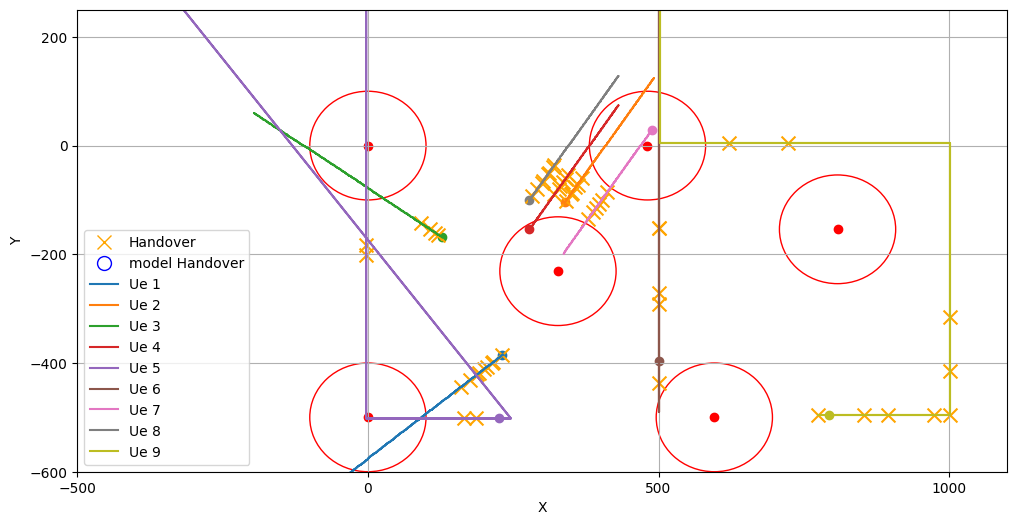

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

# 設定座標軸標籤
ax.set_xlabel('X')
ax.set_ylabel('Y')

# 設定x軸和y軸範圍
ax.set_xlim(-500, 1100)
ax.set_ylim(-600, 250)

# 設定x軸和y軸格線間隔
ax.set_xticks(np.arange(-500, 1100, 500))
ax.set_yticks(np.arange(-600, 250, 200))


for point in cell_location:
    x = point[0] 
    y = point[1]
    ax.scatter(x, y, color='red')  # 使用红色标记绘制额外的点
    circle = Circle((x, y), 100, edgecolor='red', facecolor='none')  # 绘制半径为100的圆
    ax.add_patch(circle)  # 添加圆形到图中


collect_list = []
for i in range(9):
    # 取出9个UE的X和Y值
    x = []
    y = []
    handover = []
    for k in range(cell_one_round[i]):
        x.append(ue_location[i][1][k])
        y.append(ue_location[i][2][k])
        handover.append(ue_location[i][3][k])
    
    # 繪製連線圖
    line, = ax.plot(x, y, label=f'Ue {i+1}')
    # ax.scatter(x[0], y[0], color=line.get_color(), marker='S', s=50)  # 加入起始點，并使用叉叉标记

    ax.scatter(x[0], y[0], color=line.get_color())  # 加入起始點

    heatmap_data = np.zeros((len(x), len(y)))
    
    A3_handover_num = 0
    model_handover_num = 0

     # 判斷handover_label，並添加紫色點
    for j in range(cell_one_round[i]):
        if handover[j] == 1:
            ax.scatter(x[j], y[j], color='orange', marker='x', s=100)
            A3_handover_num = A3_handover_num + 1
        if handover_store[i]['Handover'][j] == 1 and j > 2:
            ax.scatter(x[j], y[j], facecolors='none', edgecolors='blue', marker='o', s=100)
            model_handover_num = model_handover_num + 1
    print(f"ue {i + 1}, A3 handover number = {A3_handover_num}, model handover number = {model_handover_num}")
    collect_list.append([A3_handover_num, model_handover_num])


    # # 添加圖例
    # ax.legend()
legend_elements = [
    Line2D([0], [0], marker='x', color='orange', label='Handover', markerfacecolor='orange', markersize=10, linestyle='None'),
    Line2D([0], [0], marker='o', color='blue', label='model Handover', markerfacecolor='none', markersize=10, linestyle='None')
]
existing_handles, existing_labels = ax.get_legend_handles_labels()
legend_elements += existing_handles
labels = ['Handover', 'model Handover'] + existing_labels

ax.legend(handles=legend_elements, labels=labels)


plt.grid()    
plt.show()

In [107]:
print(collect_list)

[[9, 2], [6, 8], [4, 0], [6, 2], [4, 4], [5, 10], [6, 4], [8, 6], [9, 8]]


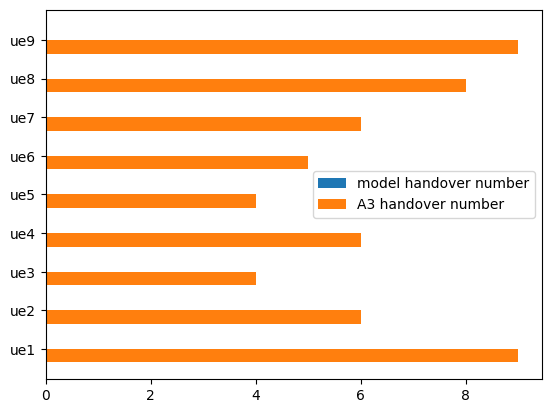

In [18]:
import numpy as np
import matplotlib.pyplot as plt


# 将数据分解为两个单独的列表
heights, widths = zip(*collect_list)

# y轴的位置
y_values = np.arange(9)

# 长条的宽度
bar_width = 0.35

# 创建一个新的figure对象
fig, ax = plt.subplots()

# 创建两个横条图
bar1 = ax.barh(y_values + bar_width, widths, bar_width, label='model handover number')
bar2 = ax.barh(y_values, heights, bar_width, label='A3 handover number')

# 设置y轴的刻度和刻度标签
ax.set_yticks(y_values + bar_width / 2)
labels = ['ue' + str(i+1) for i in range(9)]
ax.set_yticklabels(labels)

# 添加图例
ax.legend()

# 显示图形
plt.show()